# Using ARIMA predict covid cases

In [147]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import probplot
import seaborn as sns
import datetime as dt
from datetime import datetime
import altair as alt
#plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':120})

In [148]:
df_confirm = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_confirm = df_confirm.groupby('Country/Region').sum().drop(['Lat','Long'],axis=1)
df_confirm.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141
Albania,0,0,0,0,0,0,0,0,0,0,...,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568
Algeria,0,0,0,0,0,0,0,0,0,0,...,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341
Andorra,0,0,0,0,0,0,0,0,0,0,...,8586,8586,8682,8818,8868,8946,9038,9083,9083,9194
Angola,0,0,0,0,0,0,0,0,0,0,...,18193,18254,18343,18425,18613,18679,18765,18875,18926,19011


In [149]:
df_trans = df_confirm.transpose()
df_trans['World'] = df_trans.sum(axis =1)
df = df_trans.set_index(pd.DatetimeIndex(pd.to_datetime(df_trans.index.values,format="%m/%d/%y")))
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2020-01-22 to 2021-01-19
Columns: 192 entries, Afghanistan to World
dtypes: int64(192)
memory usage: 548.8 KB


In [150]:
LAST_DATE = df.index[-1]
LAST_DATE

Timestamp('2021-01-19 00:00:00')

In [151]:
def get_stationarity(timeseries,window = 5):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

**Case Chart**

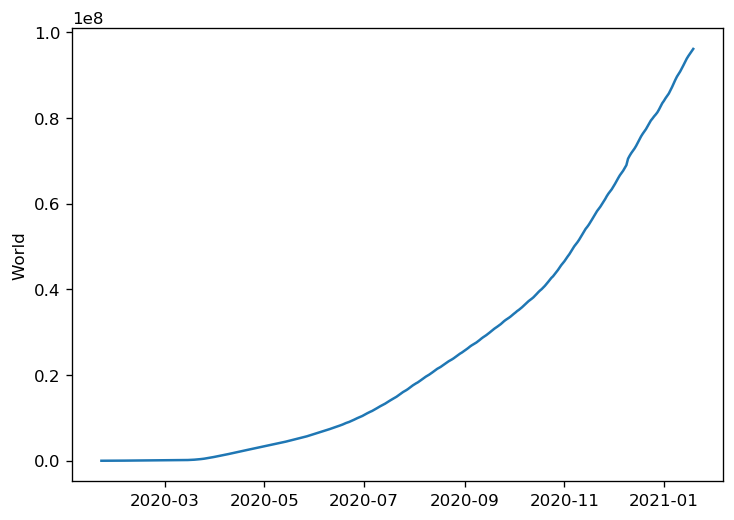

In [152]:
sns.lineplot(x=df.index,y=df.World)
plt.show()

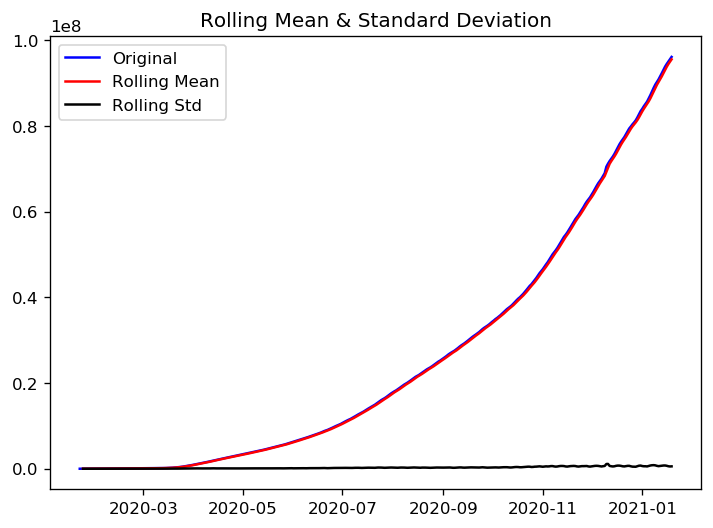

ADF Statistic: 0.9860112249435915
p-value: 0.9941161358398862
Critical Values:
	1%: -3.4491725955218655
	5%: -2.8698334971428574
	10%: -2.5711883591836733


In [153]:
get_stationarity(df['World'],window=3)

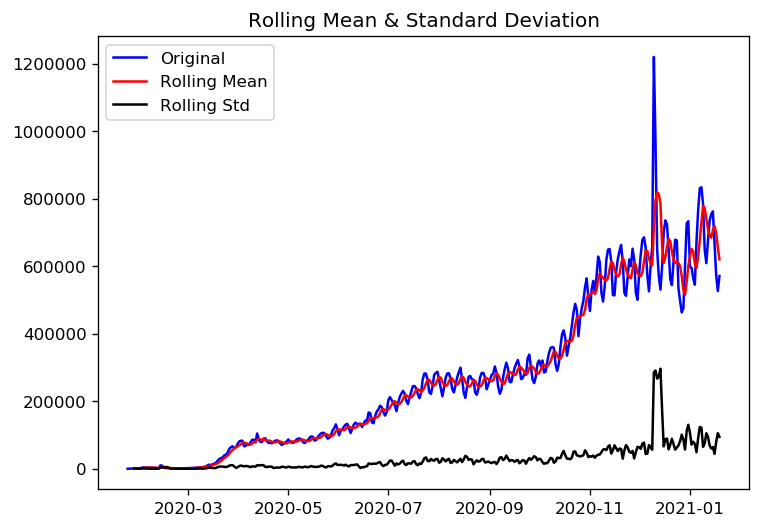

ADF Statistic: -0.2914037772371643
p-value: 0.926713021656082
Critical Values:
	1%: -3.4490648539347544
	5%: -2.8697861692116478
	10%: -2.5711631253228306


In [154]:
df_minusMA3 = df['World']-df['World'].rolling(window=3).mean()
get_stationarity(df_minusMA3.dropna())

**Case 1st diff chart**

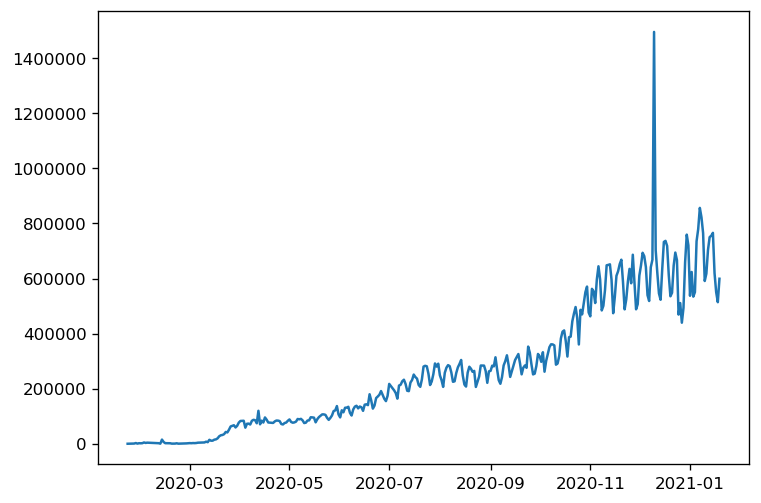

In [155]:
df_diff = df['World'].diff()
plt.plot(df_diff)

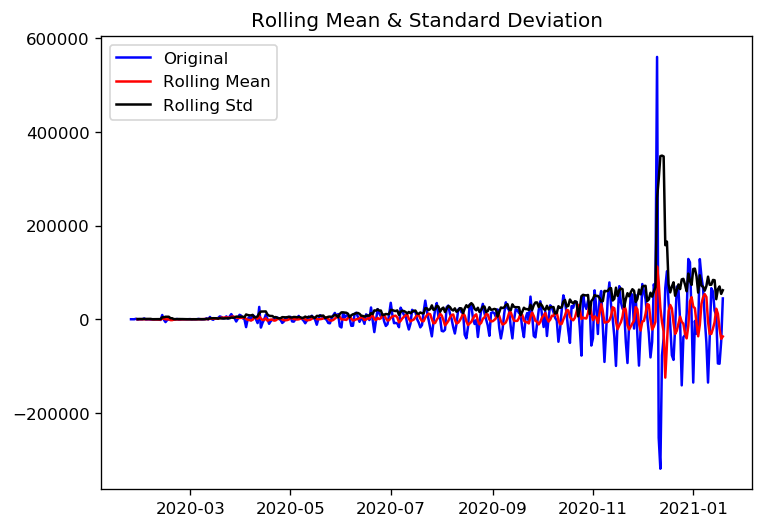

ADF Statistic: -5.7519272681338744
p-value: 5.939043894079539e-07
Critical Values:
	1%: -3.449559661646851
	5%: -2.8700035112469626
	10%: -2.5712790073013796


In [156]:
df_diff_minusMA3 = df_diff - df_diff.rolling(window=3).mean()
get_stationarity(df_diff_minusMA3.dropna())

## ARIMA Analysis
* ARIMA(p,d,q)

    AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.\
    I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.\
    MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
* Precedure
    1. Transform unstationary (varied with time) to stationary --> Time shift transformation, log transformation, etc.), 
    2. determine hyperparameter (p,d,q) --> Plot ACF/PACF to determine p,q, see after how many lags, correlation became unsignificant (either equals to 0 or some threshold like 0.5), d can be detertime by diff order
    3. Peformance Check --> Residual plot and MSE.

**Split Data**
* Doing with (90%, 10%)

In [157]:
PRED =30

In [158]:
df_train = df[:-PRED]
df_test = df[-PRED:]

2020-04-15    2.677476
2020-04-16    2.680557
2020-04-17    2.683260
2020-04-18    2.685552
2020-04-19    2.687747
                ...   
2020-12-16    2.897200
2020-12-17    2.897744
2020-12-18    2.898270
2020-12-19    2.898713
2020-12-20    2.899098
Name: World, Length: 250, dtype: float64

### 1.Transformation and Stationary Test

In [255]:
data = df_train['World']
data

2020-01-22         557
2020-01-23         655
2020-01-24         941
2020-01-25        1433
2020-01-26        2118
                ...   
2020-12-16    74278168
2020-12-17    75014795
2020-12-18    75732956
2020-12-19    76345417
2020-12-20    76880888
Name: World, Length: 334, dtype: int64

1. **Log transformation**
2. **1st/2nd diff**

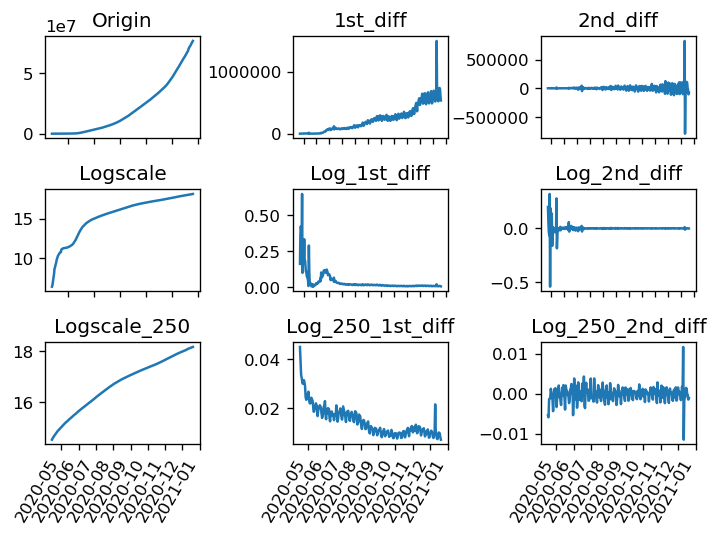

In [249]:
data = df_train['World']
fig, axes = plt.subplots(3, 3, )
plt.subplots_adjust(wspace=0.6,hspace=0.5,)
# origin
axes[0,0].plot(data)
axes[0,1].plot(data.diff().dropna())
axes[0,2].plot(data.diff().diff().dropna())
axes[0,0].set_title('Origin')
axes[0,1].set_title('1st_diff')
axes[0,2].set_title('2nd_diff')
# loglize
data = np.log(data)
axes[1,0].plot(data)
axes[1,1].plot(data.diff().dropna())
axes[1,2].plot(data.diff().diff().dropna())
axes[1,0].set_title('Logscale')
axes[1,1].set_title('Log_1st_diff')
axes[1,2].set_title('Log_2nd_diff')
# trim to 250 points
data = data[-250:]
axes[2,0].plot(data)
axes[2,1].plot(data.diff().dropna())
axes[2,2].plot(data.diff().diff().dropna())
axes[2,0].set_title('Logscale_250')
axes[2,1].set_title('Log_250_1st_diff')
axes[2,2].set_title('Log_250_2nd_diff')
fig.autofmt_xdate(rotation=60)
plt.show()

**ADF method to test stationarity**


In [160]:
def ADF_test(data):
    result = adfuller(data)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [161]:
data = df_train['World']
data_diff2 = data.diff().diff().dropna()
data_log_diff = np.log(data).diff().dropna()
data_log_diff2 = np.log(data).diff().diff().dropna()
data_250_log_diff2 = np.log(data)[-250:].diff().diff().dropna()

In [162]:
ADF_test(data_diff2)

ADF Statistic: -3.655624298665191
p-value: 0.004782448164017807
Critical Values:
	1%: -3.451281394993741
	5%: -2.8707595072926293
	10%: -2.571682118921643


In [163]:
ADF_test(data_log_diff)

ADF Statistic: -2.1958315469945093
p-value: 0.20776184207540926
Critical Values:
	1%: -3.4512146067362317
	5%: -2.870730188960711
	10%: -2.5716664849383113


In [164]:
ADF_test(data_log_diff2)

ADF Statistic: -6.259841212178849
p-value: 4.2497807892029656e-08
Critical Values:
	1%: -3.451281394993741
	5%: -2.8707595072926293
	10%: -2.571682118921643


In [165]:
ADF_test(data_250_log_diff2)

ADF Statistic: -4.8577135880206
p-value: 4.212302420990018e-05
Critical Values:
	1%: -3.4589796764641
	5%: -2.8741347158661448
	10%: -2.573482381701992


### Plot ACF/PACF

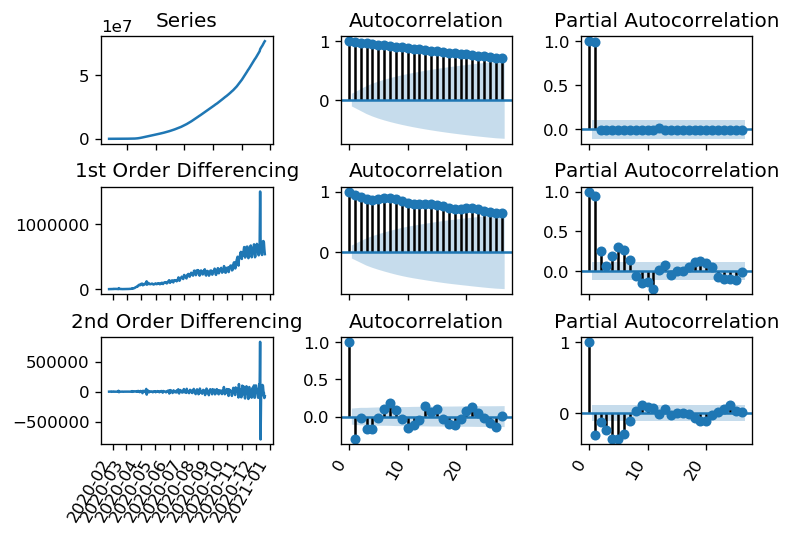

In [259]:
#series = np.log(data)
series = data
# Original Series
fig, axes = plt.subplots(3, 3)
plt.subplots_adjust(wspace=0.4,hspace=0.4,)
axes[0, 0].plot(series)
axes[0, 0].set_title('Series')
plot_acf(series, ax=axes[0, 1])
plot_pacf(series,ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), ax=axes[1, 1])
plot_pacf(series.diff().dropna(),ax=axes[1, 2])
# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(series.diff().diff().dropna(),ax=axes[2, 2])
fig.autofmt_xdate(rotation=60)
plt.show()

**See clearly on charts**

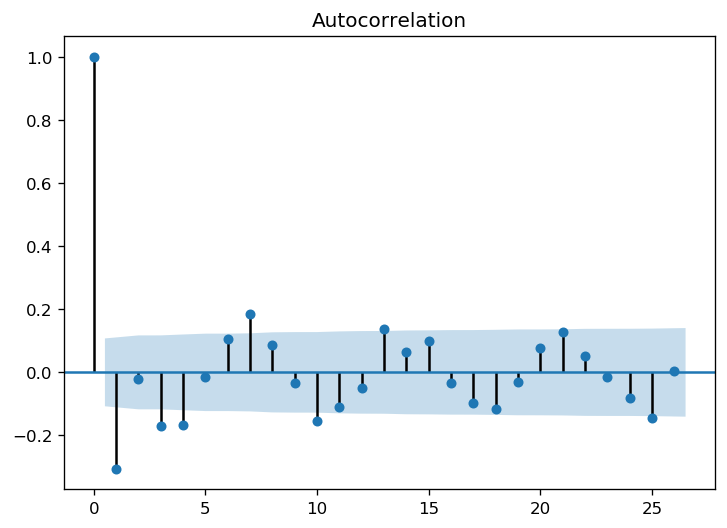

In [264]:
plot_acf(series.diff().diff().dropna())
plt.show()

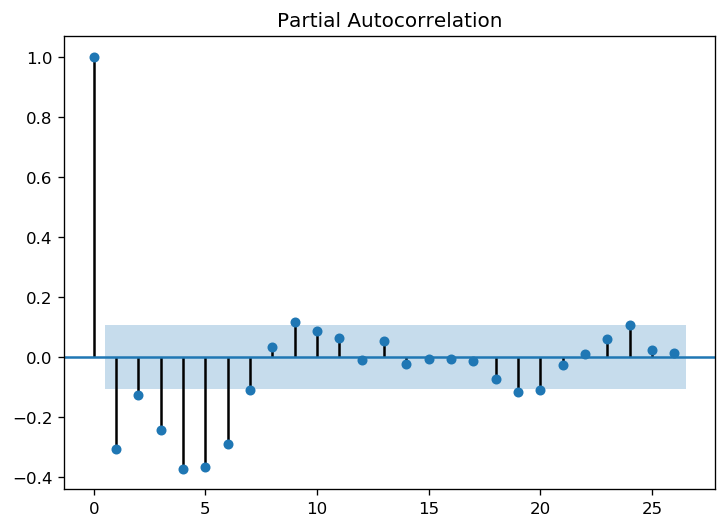

In [263]:
plot_pacf(series.diff().diff().dropna())
plt.show()

**Result:\
As we saw that data after log scaled and with diff twice had the most stable trend (smallest p-value of ADF test, so our transformation strategy would be loglized data and specify [d = 2] in ARIMA model. According to ACF/PACF chart p and q should both chose 1, but when diff equals 1 , p should chose 2 and q should chose 10.**

## Fit Model

/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/scleeza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.World   No. Observations:                  332
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4125.151
Method:                       css-mle   S.D. of innovations          60146.355
Date:                Wed, 20 Jan 2021   AIC                           8258.301
Time:                        00:55:54   BIC                           8273.522
Sample:                    01-24-2020   HQIC                          8264.371
                         - 12-20-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2030.1915    502.897      4.037      0.000    1044.532    3015.851
ar.L1.D2.World     0.2620      0.060      4.378      0.000       0.145       0.379
ma.L1.D2.World    -0.8904      0.022

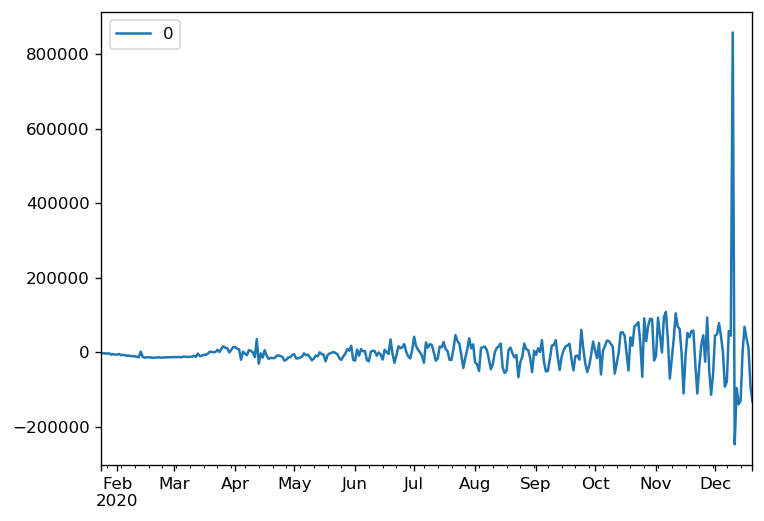

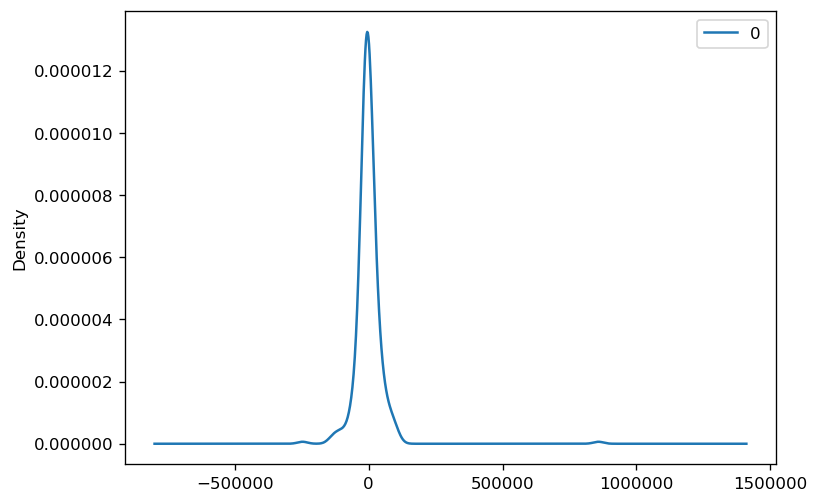

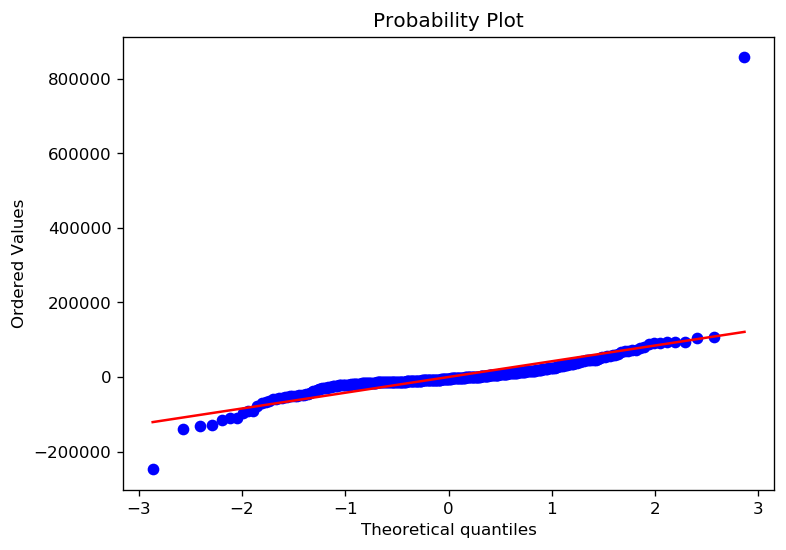

                   0
count     332.000000
mean      -59.951367
std     60237.540169
min   -247148.116325
25%    -14359.924670
50%     -4790.437397
75%     12374.241022
max    857870.806697


MSE:3617635438.474112


In [272]:
# fit model
#series = np.log(data)
series = data
model = ARIMA(series, order=(1,2,1))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
res = np.array(residuals.values)
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
probplot(residuals.values.squeeze(),plot=plt)
plt.show()
# summary stats of residuals
print(residuals.describe())
print('\n')
print("MSE:{}".format((res*res).mean()))

**Inverse to origin scale**

In [273]:
FORCAST_PREIOD = PRED

In [274]:
LAST_DATE = df_train.index[-1]

In [275]:
index = pd.date_range(start=LAST_DATE+dt.timedelta(days=1), periods=FORCAST_PREIOD)
index

DatetimeIndex(['2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19'],
              dtype='datetime64[ns]', freq='D')

In [276]:
# df_pred = pd.DataFrame(np.exp(model_fit.forecast(FORCAST_PREIOD)[0]),index=index,columns=['pred'])
# df_conf = pd.DataFrame(np.exp(model_fit.forecast(FORCAST_PREIOD)[2]),columns=['lower','upper'],index=index)
df_pred = pd.DataFrame(model_fit.forecast(FORCAST_PREIOD)[0],index=index,columns=['pred'])
df_conf = pd.DataFrame(model_fit.forecast(FORCAST_PREIOD)[2],columns=['lower','upper'],index=index)

In [279]:
trend_chart = alt.Chart(df_train.reset_index()).mark_line().encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("World:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "World:Q"]
        ).properties(width=800, height=300).interactive()

actual_chart = alt.Chart(df_test.reset_index()).mark_line(color='green').encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("World:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "World:Q"]
        ).properties(width=800, height=300).interactive()

pred_chart = alt.Chart(df_pred.reset_index()).mark_line(strokeDash=[10,5],color='orange').encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y("pred:Q",scale=alt.Scale(zero=False)),
            tooltip=["index:T", "pred:Q"]
        ).properties(width=800, height=300).interactive()

band = alt.Chart(df_conf.reset_index()).mark_area(
            opacity=0.5, color='grey'
        ).encode(
            x=alt.X("index:T",scale=alt.Scale(zero=False)),
            y=alt.Y('lower',title='cases'),
            y2=alt.Y2('upper',title='cases')
        ).properties(width=800, height=300).interactive()
trend_chart+actual_chart+pred_chart+band

alt.LayerChart(...)

In [242]:
from sklearn.metrics import mean_squared_error

In [278]:
mean_squared_error(df_test['World'],df_pred)

997542516690.8541